# DIASources detection and characterization

## PART 1:  DIASource detection and measurement in ONE CCD.

Obligatory imports

In [1]:
import pickle
import sncosmo
import numpy as np
import lsst.daf.base as dafBase
import lsst.daf.persistence as dafPersist

import re

import lsst.afw.display.ds9 as ds9

import matplotlib.pyplot as plt

from lsst.ip.diffim import ImagePsfMatchTask, DipoleMeasurementTask
from lsst.meas.base import SingleFrameMeasurementConfig
import lsst.afw.table as afwTable

import lsst.daf.base as dafBase
import DiaSourceTools as DSTools

import lsst.meas.algorithms.detection as sDet
import lsst.afw.image as afwImage

from lsst.meas.algorithms.detection import SourceDetectionTask

import skimage
from skimage import measure
from skimage import data
from skimage import filters
from scipy import ndimage
from skimage.measure import regionprops
from skimage.measure import moments
from skimage.measure import moments_central


import lsst.afw.geom as afwGeom
import random
%matplotlib inline

/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2016-04-04/lsstsw/miniconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
from matplotlib.colors import LinearSegmentedColormap
colors = [(0,0,0),(0.5,0,0), (1,0,0), (0,0,1), (1,0,1)]
cm = LinearSegmentedColormap.from_list('dipoles', colors, N=5)

colors = [(1,1,1),(0.5,0,0), (1,0,0), (0,0,1), (1,0,1)]
cm2 = LinearSegmentedColormap.from_list('dipoles', colors, N=5)

def SubtractBackground(exp):
  
    bgConf = sDet.BackgroundConfig()
    background,Exp0 = sDet.estimateBackground(exp,bgConf,True)

    return background, Exp0

def merge_sources(results):
    table = afwTable.SourceTable.make(schema)
    table.setMetadata(algMetadata)
    fpSet = results.fpSets.positive
    fpSet.merge(results.fpSets.negative, 1, 1, False)
    diaSources = afwTable.SourceCatalog(table)
    fpSet.makeSources(diaSources)
    return diaSources

def remove_nan_sources(diaSources):
    c_diaSources = diaSources.copy()
    c_diaSources.clear()
    for diaSrc in diaSources:
        val = diaSrc.get("coord_ra").asArcseconds()
        if np.isnan(val) == False:
            c_diaSources.append(diaSrc)
        
    return c_diaSources

def get_source_stamp(src, visit, filter, ccds, offset=0):
    
    for ccd in ccds:

        if butler.datasetExists("deepDiff_differenceExp", {'visit': visit , 'filter':filter , 'ccd':ccd}):

            diffExp = butler.get("deepDiff_differenceExp", {'visit': visit , 'filter':filter , 'ccd':ccd})
            bbox = diffExp.getBBox()
            wcs = diffExp.getWcs()
            
            c = afwGeom.Point2I(wcs.skyToPixel(src.getRa(), src.getDec()))
            
            if bbox.contains(c):
                psf = diffExp.getPsf()
                shape = psf.computeShape()
                sigma = shape.getDeterminantRadius()
                #print sigma
                
                return DSTools.get_stamp(src, diffExp, offset=offset), c
            
    return None, None  

def get_dipole_lobes_metrics(stamp):
    
    w,h = stamp.getWidth(), stamp.getHeight()
    pos_fp = stamp.getMaskedImage().getMask().getPlaneBitMask("DETECTED")
    neg_fp = stamp.getMaskedImage().getMask().getPlaneBitMask("DETECTED_NEGATIVE")

    img_arr, mask_arr, var_arr = stamp.getMaskedImage().getArrays()
    
    values = (mask_arr & pos_fp == pos_fp)
    values2 = values & (img_arr > 0)
    pos_pixels = len(img_arr[values])
    pos_flux=  np.sum(abs(img_arr[values2]))

    values = (mask_arr & neg_fp == neg_fp)
    values2 = values & (img_arr < 0)
    neg_flux= np.sum(abs(img_arr[values2]))
    neg_pixels = len(img_arr[values])

    values = mask_arr & (neg_fp|pos_fp) == (neg_fp|pos_fp)
    inter_flux = np.sum(abs(img_arr[values]))
    inter_pixels = len(img_arr[values])

    values = mask_arr & (neg_fp|pos_fp) != 0
    total_flux = np.sum(abs(img_arr[values]))
    mask_pixels = len(img_arr[values])
    
    fluxes = [inter_flux/total_flux, pos_flux/total_flux, neg_flux/total_flux]
    geom = [float(inter_pixels)/mask_pixels, float(pos_pixels)/mask_pixels, float(neg_pixels)/mask_pixels]
    

    return fluxes, geom
    

def show_stamps(stamp, title='Stamp'):

    img_arr, mask_arr, var_arr = stamp.getMaskedImage().getArrays()
    w,h = stamp.getWidth(), stamp.getHeight()
    plt.figure(figsize=(16,5))
    
    plt.suptitle(title)
    
    plt.subplot(1,3,1)
    plt.imshow(img_arr, origin='lower', vmin=img_arr.min(), vmax=img_arr.max(), cmap='gray', extent=(0,w-1, 0, h-1), interpolation='none')


    plt.subplot(1,3,2)
    plt.imshow(mask_arr, origin='lower',  vmin=0, vmax=mask_arr.max(), cmap=cm, extent=(0,w-1, 0, h-1), interpolation='none')


    plt.subplot(1,3,3)
    layer_mask = mask_arr.copy()
    layer_mask = np.ma.masked_where(layer_mask==0, layer_mask)
    plt.imshow(img_arr, origin='lower', vmin=img_arr.min(), vmax=img_arr.max(), cmap='gray', extent=(0,w-1, 0, h-1), interpolation='none')
    plt.imshow(layer_mask, origin='lower', alpha=0.3, vmin=0, vmax=mask_arr.max(), cmap=cm, extent=(0,w-1, 0, h-1), interpolation='none')
    
def visualize_dipoles_and_planes(stamp, source):
    
    plCak = source.getFootprint().getPeaks()
    
    w,h = stamp.getWidth(), stamp.getHeight()
    img_arr, mask_arr, var_arr = stamp.getMaskedImage().getArrays()

    plt.figure(figsize=(16,5))

    plt.subplot(1,2,1)
    plt.imshow(img_arr, origin='lower', vmin=img_arr.min(), vmax=img_arr.max(), cmap='gray', extent=(0,w-1, 0, h-1), interpolation='none')

    for pk in pkCat:
        if pk.getPeakValue() < 0:
            plt.plot(pk.getIx()-stamp.getX0(), pk.getIy()-stamp.getY0(), 'bo')
        else:
            plt.plot(pk.getIx()-stamp.getX0(), pk.getIy()-stamp.getY0(), 'ro')

    plt.subplot(1,2,2)
    im = plt.imshow(mask_arr, origin='lower', vmin=0, vmax=100, cmap=cm, extent=(0,w-1, 0, h-1), interpolation='none')
    
def photo_dipole(photo_prop):
    return photo_prop[1] < 0.66 and photo_prop[2] < 0.66

def geom_dipole(geom_prop):
    return geom_prop[0]<0.33


This part is <b>very important</b>. Detection and measurement tasks are going to use the same schema, which is gonna be modified to contain all measurement fields upon the task instantiation. Not doing the task instantiation before running the measurement is going to cause errors. You've been warned

In [3]:
algMetadata = dafBase.PropertyList()
schema = afwTable.SourceTable.makeMinimalSchema()

dipoleMeasurement = DipoleMeasurementTask

config = dipoleMeasurement.ConfigClass()
dipoleMeasurement = dipoleMeasurement(schema, algMetadata=algMetadata)

In-disk path to dataset

In [4]:
DATADIR="/renoir_data_02/jpreyes/lsst_data/CFHTLS_master/"
butler = dafPersist.Butler(DATADIR+"/output")


Background subtraction function

These lines allow to calculate the psf for the image. However, if the background is transformed into an array and the standard deviation is calculated, the sigma value is going to be different.

## Part 2:  DIASource detection and measurement in the field.

Set of useful methods to automatize the whole process.

The visit is a hard-coded value. This loop runs over all ccds for the given visit, detect the DIASources on the difference image, remove the DIASources with NaN coordinates and perform the measurement.

A list of catalogs is generated by varying the $\sigma$ multiple for the detection.

In [5]:
def detect_point_source(stamp, center, alpha=1):
    
    img_arr, mask_arr, var_arr = stamp.getMaskedImage().getArrays()
    
    mean = np.mean(img_arr)
    std = np.std(img_arr)
    T_p = mean + alpha*std
    T_n = mean - alpha*std

    #thresholding_n = img_arr > T_n
    thresholding_n = img_arr < T_p
    thresholding_p = img_arr < T_p
    thresholding = thresholding_p & thresholding_n
    
    w, h = stamp.getWidth(), stamp.getHeight()
    
    t_img_arr = img_arr.copy()
    t_img_arr[thresholding] = 0

    t_img_arr = t_img_arr.astype(float)

    m_c = moments_central(t_img_arr, center.getX()-stamp.getX0(), center.getY()-stamp.getY0(), order=2)
    

    cov = [[m_c[2,0]/m_c[0,0], m_c[1,1]/m_c[0,0]], [m_c[1,1]/m_c[0,0], m_c[0,2]/m_c[0,0]]]
    #print(np.matrix(cov))
    vals, vectors = np.linalg.eig(cov)
    
    return ( 2*np.sqrt(vals[0]), 2*np.sqrt(vals[1])), t_img_arr 

In [6]:

def classify_point_source(stamp, center):
        try:
            axes, im = detect_point_source(stamp, center)

            h_m, w_m = stamp.getWidth()/2, stamp.getHeight()/2

            if np.isnan(axes[0])==True or np.isnan(axes[1])==True or axes[0] > h_m or axes[1] > w_m:


                return "Point positive"
            else:
                return "Positive"

        except np.linalg.linalg.LinAlgError as e:
                return "Point positive"

In [45]:
def classify_sources(visit, filter, sigma, ccd, butler, dipoleMeasurement):
    
        source_catalog = None
        

        if butler.datasetExists("deepDiff_differenceExp", {'visit': visit , 'filter':filter , 'ccd':ccd}):

                diffExp = butler.get("deepDiff_differenceExp", {'visit': visit , 'filter':filter , 'ccd':ccd})
                try:
                            results = DSTools.detect_diasources(diffExp, doSmooth=False, threshold=sigma)
                            diaSources = merge_sources(results)
                            dipoleMeasurement.run(diaSources, diffExp)
                            source_catalog = remove_nan_sources(diaSources)                
                            
                except Exception, e:
                            print "exception"
                            print e
                        
    
        classification = []
        if source_catalog is None:
            return  dipoleMeasurement
        
        for source in source_catalog:
            
            bbox = diffExp.getBBox()
            wcs = diffExp.getWcs()
            
            center = afwGeom.Point2I(wcs.skyToPixel(source.getRa(), source.getDec()))
            
                  
            stamp = DSTools.get_stamp(source, diffExp, offset=10)
            
        
            if stamp is not None:
                stamp_clone = stamp.clone()
                results = DSTools.detect_diasources(stamp_clone, doSmooth=False,threshold=sigma)


                if len(results.fpSets.positive.getFootprints()) == 0 and len(results.fpSets.negative.getFootprints()) > 0:
                    
                    classification.append(('Negative', source, visit))
                elif len(results.fpSets.positive.getFootprints()) > 0 and len(results.fpSets.negative.getFootprints()) == 0:
                    classification.append((classify_point_source(stamp_clone, center), source, visit))
                else:
                    try:
                        label = 'Dipole'
                        stamp_clone = stamp.clone()
                        results = DSTools.detect_diasources(stamp_clone, doSmooth=False,threshold=6)
                        photo, geom = get_dipole_lobes_metrics(stamp_clone)

                        p_dipole, g_dipole = photo_dipole(photo), geom_dipole(geom)

                        if p_dipole and g_dipole:
                            label = "Dipole type I"
                        elif p_dipole and not g_dipole:
                            label = "Dipole type II"
                        elif not p_dipole and g_dipole:
                            label = "Fringe"
                        else:
                            label = "Artifact"
                        classification.append((label, source, visit))
                        
                    except Exception, e:

                            print e
                            label = "Artifact"
                            classification.append((label, source, visit))
                            
        
        return classification

In [18]:
import time

start = time.time()
classification  = classify_sources(849687, 'r', 6, 14, butler)
end = time.time()
print "Total time: " + str(end-start)

/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2016-04-04/lsstsw/miniconda/lib/python2.7/site-packages/ipykernel/__main__.py:65: RuntimeWarning: invalid value encountered in greater
/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2016-04-04/lsstsw/miniconda/lib/python2.7/site-packages/ipykernel/__main__.py:70: RuntimeWarning: invalid value encountered in less


Total time: 4.82793307304


OrderedDict([('Dipole type I', 40), ('Fringe', 34), ('Dipole type II', 30), ('Point positive', 13), ('Positive', 10), ('Artifact', 5)])


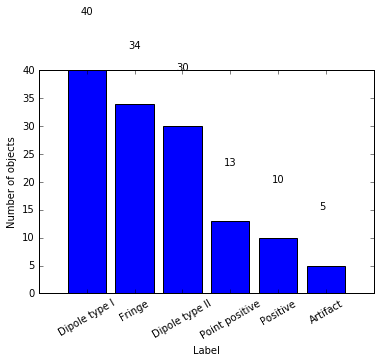

In [17]:
import collections
from operator import itemgetter

objects = {}

#classification = res[0]
for label, src, visit in classification:
    if label in objects:
        objects[label] += 1
    else:
        objects[label] = 1

o_objects = collections.OrderedDict(sorted(objects.items(), key=itemgetter(1), reverse=True))
print o_objects
X = np.arange(len(o_objects))

p = plt.bar(X, o_objects.values(), align='center')
plt.xticks(X, o_objects.keys(), rotation=30)

plt.xlabel("Label")
plt.ylabel("Number of objects")
for i, rect in enumerate(p):
    plt.text(rect.get_x()+ rect.get_width()/3, rect.get_height()+10, int(rect.get_height()))

plt.show()

Positive


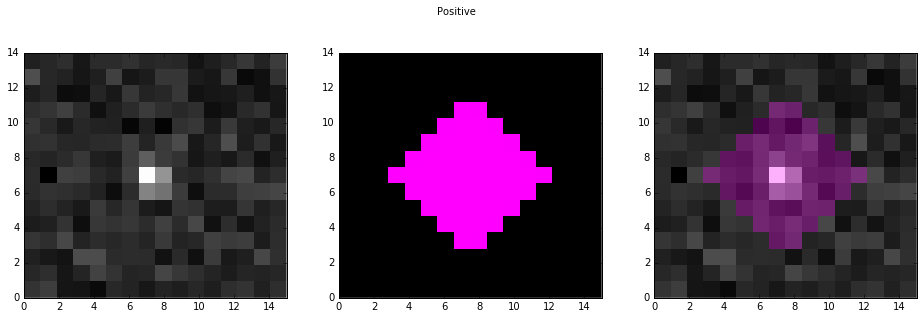

In [51]:
visit = 849687
ccds = range(0,36)
count = 0
while count < 1:
    label, source = random.choice(classification)
    while label != "Positive":
        label, source = random.choice(classification)
    print label
        
    stamp, center = get_source_stamp(source, visit, 'r',ccds, offset=10)
    stamp_clone = stamp.clone()
    results = DSTools.detect_diasources(stamp_clone, doSmooth=False,threshold=6)
    show_stamps(stamp_clone, title=label)
    count +=1

(5.0003255836204552, 2.4901150204215825)


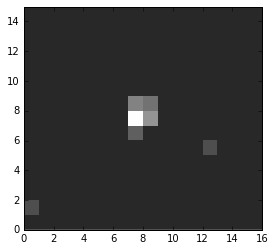

In [53]:
img_arr, mask_arr, var_arr = stamp_clone.getMaskedImage().getArrays()

mean = np.mean(img_arr)
std = np.std(img_arr)
T_p = mean + 1*std
T_n = mean - 1*std

thresholding_n = img_arr > T_n
thresholding_n = img_arr < T_p
thresholding_p = img_arr < T_p
thresholding = thresholding_p & thresholding_n
w, h = stamp_clone.getWidth(), stamp_clone.getHeight()

t_img_arr = img_arr.copy()
t_img_arr[thresholding] = 0

t_img_arr = t_img_arr.astype(float)

plt.imshow(t_img_arr,  vmin=img_arr.min(), vmax=img_arr.max(), cmap='gray',  interpolation='none', extent=(0,w,0,h))

m_c = moments_central(t_img_arr, center.getX()-stamp_clone.getX0(), center.getY()-stamp_clone.getY0(), order=2)
#plt.plot(center.getX()-stamp_clone.getX0(), center.getY()-stamp_clone.getY0(), 'rx')

cov = [[m_c[2,0]/m_c[0,0], m_c[1,1]/m_c[0,0]], [m_c[1,1]/m_c[0,0], m_c[0,2]/m_c[0,0]]]
#print(np.matrix(cov))
vals, vectors = np.linalg.eig(cov)

print( 2*np.sqrt(vals[0]), 2*np.sqrt(vals[1])) 

In [62]:
import ipyparallel as ipyp

c = ipyp.Client()
v = c[:]


def f(a,b):
    def c(a, b):
        return a+b

    return c(a,b)
#res = v.map(lambda x,y: x+y, (1, 2, 3, 4), (2, 3, 4, 5))
res = v.map(f, [1, 2, 3, 4], [2, 3, 4, 5])

print res.get()



[3, 5, 7, 9]


In [31]:
visits = (850177, 850178, 850179, 850180, 850181, 850586, 850587, 850588, 850589, 850590,)
filters = ['r']*10
sigmas = [6]*10
butlers = [butler]*10


In [47]:
n = 4
visits = [849687]*n
filters = ['r']*n
sigmas = [6]*n
butlers = [butler]*n
ccds = range(0,n)
dmt = [dipoleMeasurement]*n
print ccds

[0, 1, 2, 3]


In [56]:
dipoleMeasurement

In [53]:
import time

c = ipyp.Client()
v = c[:]

start = time.time()
#res = v.map(classify_sources, visits, filters, sigmas, ccds, butlers)
res = v.map(classify_sources, [849687], ['r'], [6], [14], [butler], [dipoleMeasurement])
end = time.time()
print "Total time: " + str(end-start)


Total time: 0.00718998908997


In [54]:
print res

<AsyncMapResult: classify_sources:finished>


In [55]:
print res.get()

CompositeError: one or more exceptions from call to method: classify_sources
[0:apply]: TypeError: ('__init__() takes at most 3 arguments (5 given)', <class 'lsst.ip.diffim.dipoleMeasurement.DipoleMeasurementTask'>, (lsst.ip.diffim.dipoleMeasurement.DipoleMeasurementConfig(doApplyApCorr='noButWarn', classification={'maxFluxRatio': 0.65, 'minSn': 7.0710678118654755}, doReplaceWithNoise=False, applyApCorr={'ignoreList': [], 'doFlagApCorrFailures': True}, noiseReplacer={'noiseSeedMultiplier': 1, 'noiseOffset': 0.0, 'noiseSource': 'measure'}, plugins={'values': {'base_CircularApertureFlux': {'doMeasure': True, 'shiftKernel': 'lanczos5', 'radii': [3.0, 4.5, 6.0, 9.0, 12.0, 17.0, 25.0, 35.0, 50.0, 70.0], 'maxSincRadius': 10.0}, 'base_PsfFlux': {'doMeasure': True, 'badMaskPlanes': []}, 'ip_diffim_PsfDipoleFlux': {'doMeasure': True, 'stepSizeFlux': 1.0, 'maxFnCalls': 100000, 'stepSizeCoord': 0.10000000149011612, 'errorDef': 1.0}, 'base_FPPosition': {'doMeasure': True}, 'base_NaiveCentroid': {'doMeasure': True, 'background': 0.0}, 'base_PixelFlags': {'doMeasure': True, 'masksFpCenter': [], 'masksFpAnywhere': []}, 'base_SkyCoord': {'doMeasure': True}, 'base_ScaledApertureFlux': {'doMeasure': True, 'shiftKernel': 'lanczos5', 'scale': 3.14}, 'base_InputCount': {'doMeasure': True}, 'base_Variance': {'doMeasure': True, 'scale': 5.0, 'mask': ['DETECTED', 'DETECTED_NEGATIVE', 'BAD', 'SAT']}, 'ip_diffim_NaiveDipoleFlux': {'doMeasure': True}, 'base_Jacobian': {'doMeasure': True, 'pixelScale': 0.5}, 'base_GaussianCentroid': {'doMeasure': True}, 'base_PeakLikelihoodFlux': {'doMeasure': True, 'warpingKernelName': 'lanczos4'}, 'base_SdssCentroid': {'doMeasure': True, 'peakMin': -1.0, 'binmax': 16, 'wfac': 1.5}, 'base_Blendedness': {'doMeasure': True, 'doShape': True, 'doOld': True, 'doFlux': True, 'nSigmaWeightMax': 3.0}, 'base_GaussianFlux': {'doMeasure': True, 'background': 0.0}, 'base_ClassificationExtendedness': {'doMeasure': True, 'psfErrFactor': 0.0, 'modelErrFactor': 0.0, 'fluxRatio': 0.925}, 'base_SdssShape': {'maxShift': 0.0, 'tol2': 9.999999747378752e-05, 'tol1': 9.999999747378752e-06, 'doMeasure': True, 'background': 0.0, 'maxIter': 100}, 'base_PeakCentroid': {'doMeasure': True}, 'ip_diffim_NaiveDipoleCentroid': {'doMeasure': True}}, 'names': ['base_CircularApertureFlux', 'ip_diffim_NaiveDipoleCentroid', 'ip_diffim_PsfDipoleFlux', 'base_PixelFlags', 'base_SkyCoord', 'base_PsfFlux', 'ip_diffim_NaiveDipoleFlux']}, slots={'calibFlux': None, 'apFlux': 'base_CircularApertureFlux_3_0', 'instFlux': None, 'shape': None, 'centroid': 'ip_diffim_NaiveDipoleCentroid', 'modelFlux': None, 'psfFlux': 'base_PsfFlux'}), 'dipoleMeasurement', None, None))

In [46]:
import time

start = time.time()

for ccd in ccds:
    classification  = classify_sources(849687, 'r', 6, 14, butler, dipoleMeasurement)
end = time.time()
print "Total time: " + str(end-start)

/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2016-04-04/lsstsw/miniconda/lib/python2.7/site-packages/ipykernel/__main__.py:65: RuntimeWarning: invalid value encountered in greater
/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2016-04-04/lsstsw/miniconda/lib/python2.7/site-packages/ipykernel/__main__.py:70: RuntimeWarning: invalid value encountered in less


Total time: 18.0676350594


In [65]:
source_catalog[10].get("id")

11L

In [66]:
diffExp = butler.get("deepDiff_differenceExp", {'visit': 849687 , 'filter':'r' , 'ccd':28})